In [6]:
import umap.umap_ as umap
import pandas as pd
import numpy as np
import sklearn.preprocessing
import seaborn as sns
import librosa
import librosa.display
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import StandardScaler

In [7]:
SR = 16000  # Sample rate
DURATION = 1.0
N_FFT = 2048
HOP_LENGTH = 256
N_MELS = 128
FIXED_SHAPE = (N_MELS, int(SR * DURATION / HOP_LENGTH) + 1)
SAMPLES_PER_WORD = 15

In [8]:
def generate_spectrogram(audio_path):
    try:
        # Load with fixed duration (pad/trim as needed)
        y, sr = librosa.load(audio_path, sr=SR, duration=DURATION)
        if len(y) < SR * DURATION:
            y = np.pad(y, (0, max(0, int(SR * DURATION) - len(y))))

        # Generate spectrogram matching original parameters
        S = np.abs(librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH))

        # Convert to dB scale
        S_db = librosa.amplitude_to_db(S, ref=np.max)

        return S_db.flatten()  # Flatten for UMAP input

    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None

In [9]:
# Get audio files and labels
wavs = list(Path("mswc_microset/mswc_microset/en/clips").rglob("*.opus"))
labels = [w.parts[-2] for w in wavs]

In [10]:
word_samples = defaultdict(list)
for wav in wavs:
    word = wav.parts[-2]
    if len(word_samples[word]) < SAMPLES_PER_WORD:
        word_samples[word].append(wav)

In [11]:
selected_wavs = []
selected_labels = []
for word, paths in word_samples.items():
    selected_wavs.extend(paths)
    selected_labels.extend([word] * len(paths))
print(f"Selected {len(selected_wavs)} files ({len(word_samples)} words)")

Selected 465 files (31 words)


In [12]:
spectrograms = []
valid_labels = []
for wav, label in zip(selected_wavs, selected_labels):
    spec = generate_spectrogram(str(wav))
    if spec is not None:
        spectrograms.append(spec)
        valid_labels.append(label)

spectrograms = np.array(spectrograms)
print(f"Final spectrogram array shape: {spectrograms.shape}")

Final spectrogram array shape: (465, 64575)


In [13]:
scaler = StandardScaler(with_mean=True, with_std=True)
scaled_embeddings = scaler.fit_transform(spectrograms)

In [14]:
reducer = umap.UMAP(
    n_neighbors=15,       # Original default
    min_dist=0.1,         # Original default
    metric='euclidean',   # Original default
    random_state=42       # For reproducibility
)
projection = reducer.fit_transform(scaled_embeddings)

C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [15]:
df = pd.DataFrame({
    'x': projection[:, 0],
    'y': projection[:, 1],
    'keyword': valid_labels
})

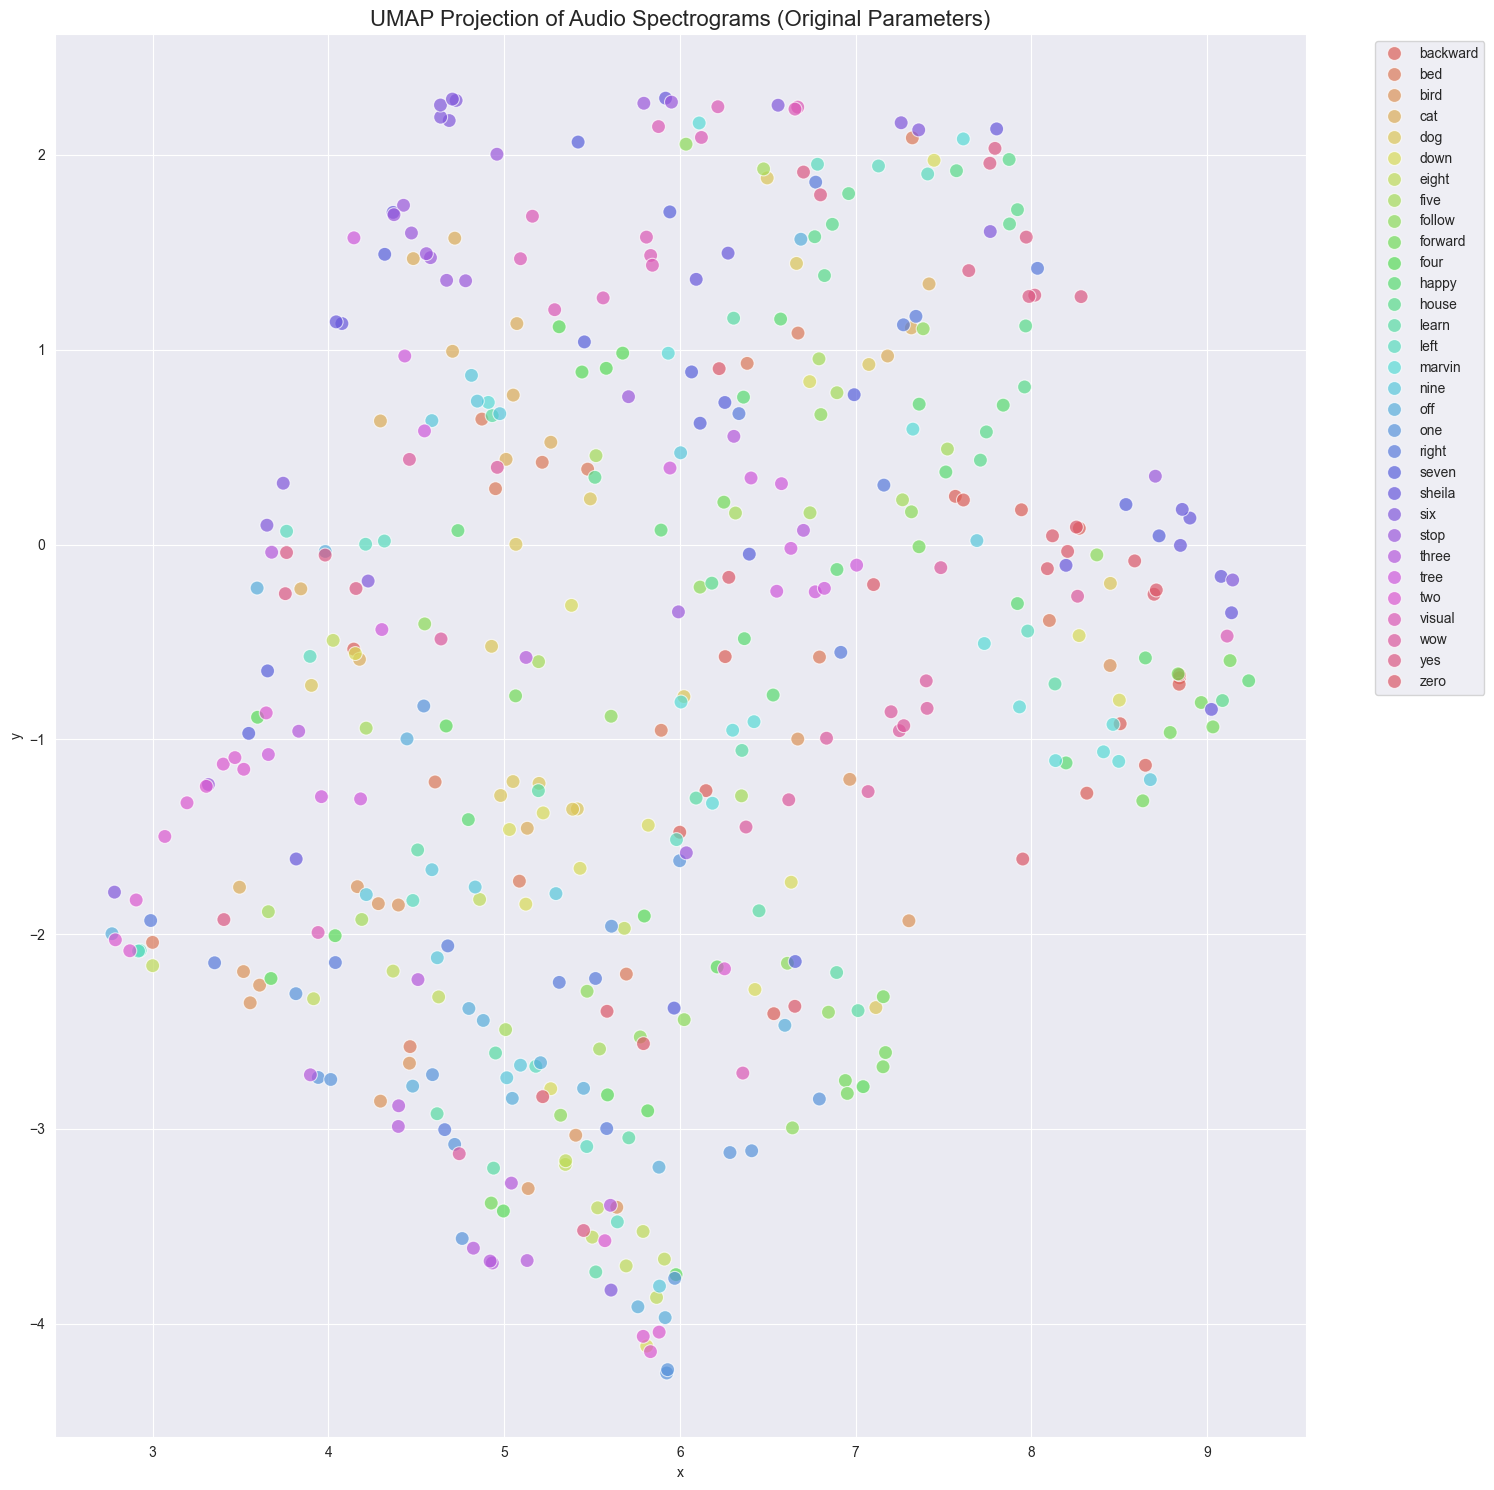

In [16]:
plt.figure(figsize=(15, 15))
sns.scatterplot(
    x='x', y='y',
    hue='keyword',
    data=df,
    palette=sns.color_palette("hls", n_colors=len(set(valid_labels))),
    s=100,
    alpha=0.7
)

plt.title("UMAP Projection of Audio Spectrograms (Original Parameters)", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()